In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support

train_data = pd.read_excel("data/cases_2021_train_processed_2.xlsx")
test_data = pd.read_excel("data/cases_2021_test_processed_unlabelled_2.xlsx")

# 1.1 Feature Selection

In [51]:
train = train_data.copy()
train = train[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio','outcome_group']]
test = test_data.copy()
test = test[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio']]
train_data, test_data = train,test 

# 1.2 Feature Mapping

In [52]:
train = train_data.copy()
train['country'] = pd.factorize(train['country'])[0]
train['chronic_disease_binary'] = pd.factorize(train['chronic_disease_binary'])[0]
new_label = {"outcome_group": {"deceased": 0, "hospitalized": 1, "nonhospitalized": 2}}
train.replace(new_label, inplace = True)
test = test_data.copy()
test['country'] = pd.factorize(test['country'])[0]
test['chronic_disease_binary'] = pd.factorize(test['chronic_disease_binary'])[0]
train_data, test_data = train,test 

# 1.3 Balancing Classes


Before Balancing,
outcome_group
0      997
1    13241
2     2974
dtype: int64


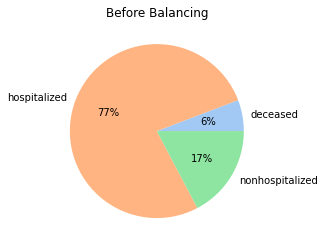


After Balancing,
outcome_group
0     9970
1    10579
2     9814
dtype: int64


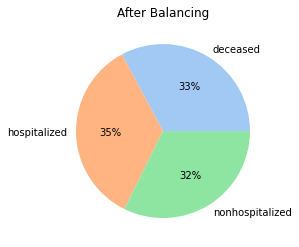

In [53]:
def show_train_dataset_pie_chart(train_dataset: pd.DataFrame, title: str):
    plt.figure()
    data = train_dataset.groupby("outcome_group").size()
    print("\n" + title + ",")
    print(data)
    data = [int(data[0]), int(data[1]), int(data[2])]
    labels = ["deceased", "hospitalized", "nonhospitalized"]
    colours = sns.color_palette('pastel')[0:4]
    plt.pie(x=data, labels=labels, colors=colours, autopct='%.0f%%')
    plt.title(title)
    plt.show()

show_train_dataset_pie_chart(train_data, "Before Balancing")

deceased = train_data[train_data["outcome_group"] == 0]
new_deceased = deceased.sample(frac=10, replace=True, random_state=1)
new_deceased.reset_index(inplace=True, drop=True)

hospitalized = train_data[train_data["outcome_group"] == 1]
hospitalized_sample = np.random.choice(hospitalized.index, 3000, replace=True)
new_hospitalized = hospitalized.drop(hospitalized_sample)
new_hospitalized.reset_index(inplace=True, drop=True)

nonhospitalized = train_data[train_data["outcome_group"] == 2]
new_nonhospitalized = nonhospitalized.sample(frac=3.3, replace=True, random_state=1)
new_nonhospitalized.reset_index(inplace=True, drop=True)

new_train = pd.concat([new_deceased, new_hospitalized, new_nonhospitalized])
new_train.sort_index(axis = 0, inplace=True)
new_train.reset_index(inplace=True, drop=True)

show_train_dataset_pie_chart(new_train, "After Balancing")

train_data = new_train

# 1.4 Building Models

### Train/Validation Split,

In [54]:
train_data, validation_data = train_test_split(train_data, test_size=0.2)

### XG Boost,

In [55]:
# Takes about 4 minutes to run.

# Decide number of k-fold splits
k = 5
# Create model with blank parameters
model = xgb.XGBClassifier(random_state = 1)
# Create space of possible parameters
parameter_search_space = {
    "learning_rate": [0.2, 0.3],
    "max_depth": [6, 8, 10],
    "n_estimators": [150, 250],
    "objective": ["multi:softmax"],
    "num_class": [3]
}
# Create grid search cross validation object
grid_search_cv = GridSearchCV(
    estimator=model,
    param_grid=parameter_search_space,
    scoring="f1_macro",
    cv=k,
    verbose=10
)
# Put data and labels in proper format
data = train_data.iloc[:, :4].values
labels = train_data.iloc[:, 4].values.reshape(-1, 1)
# Fit grid search object
grid_search_cv.fit(data, labels)
# Print and save results.
print("XG Boost GridSearchCV best score = " + str(grid_search_cv.best_score_))
print("XG Boost GridSearchCV best parameters = " + str(grid_search_cv.best_params_))
predictions = grid_search_cv.predict(data)
_, _, fscore, _ = precision_recall_fscore_support(predictions, labels)
print("XG Boost GridSearchCV deceased class f1-score = " + str(fscore[0]))
pd.DataFrame(grid_search_cv.cv_results_).to_csv("xgboost_results.csv")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 1/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.811 total time=   3.9s
[CV 2/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 2/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.817 total time=   3.0s
[CV 3/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 3/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.810 total time=   2.5s
[CV 4/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 4/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objectiv

# 1.5 Check for overfitting

# 1.7 Prediction on test sets